In [9]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV1
from torch_geometric.data import DataLoader 
from model import Net
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [10]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV1(testpath, max_events=500, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])



### Loading data


  0%|                                                     | 0/1 [00:33<?, ?it/s]

Reached 500!



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
print(data_test[0].assoc)

In [ ]:
print(data_test)

In [ ]:
# Also load explicitely, used for analysis and plots
data_path = '/vols/cms/mm1221/Data/100k/5e/test/raw/test.root'
data_file = uproot.open(data_path)

ass = data_file['associations']['tsCLUE3D_recoToSim_CP'].array()

Track_ind = data_file['tracksters;1']['vertices_indexes'].array()
GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()
GT_bc = data_file['simtrackstersCP;3']['barycenter_x'].array()
energies = data_file['clusters;3']['energy'].array()
LC_x = data_file['clusters;3']['position_x'].array()
LC_y = data_file['clusters;3']['position_y'].array()
LC_z = data_file['clusters;3']['position_z'].array()
LC_eta = data_file['clusters;3']['position_eta'].array()
#MT_ind = data_file['trackstersMerged;2']['vertices_indexes'].array()

#1.3 Filter so get rid of events with 0 calo particles
skim_mask = []
for e in GT_bc:
    if 1 <= len(e) <= 5:
        skim_mask.append(True)
    else:
        skim_mask.append(False)

Track_ind = Track_ind[skim_mask]
GT_ind = GT_ind[skim_mask]
GT_mult = GT_mult[skim_mask]
energies = energies[skim_mask]
LC_x = LC_x[skim_mask]
LC_y = LC_y[skim_mask]
LC_z = LC_z[skim_mask]
LC_eta = LC_eta[skim_mask]
#MT_ind = MT_ind[skim_mask]
ass = ass[skim_mask]






In [ ]:
import awkward as ak

def filter_repeated_indexes(GT_ind, GT_mult):
    """
    Given:
       - GT_ind: an awkward array (or list of lists) of indexes for one event.
       - GT_mult: an awkward array (or list of lists) of multiplicity values (same shape as GT_ind).
    
    For any index that appears in more than one sub-array, keep only the occurrence with the
    smallest multiplicity, and set that multiplicity to 1.0. All other occurrences are removed.
    
    Returns:
       new_GT_ind, new_GT_mult  
         Both are returned as <class 'awkward.highlevel.Array'>.
    """
    # 1. Record all occurrences of each index.
    occurrences = {}
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            occurrences.setdefault(val, []).append((sub_i, pos, mult))
    
    # 2. Mark occurrences to remove and those to update.
    removals = set()
    update_to_one = set()
    
    for index_val, occ_list in occurrences.items():
        if len(occ_list) > 1:
            occ_list_sorted = sorted(occ_list, key=lambda x: x[2])  # Sort by multiplicity
            kept_occ = occ_list_sorted[0]  # Keep lowest multiplicity
            update_to_one.add((kept_occ[0], kept_occ[1]))
            for occ in occ_list_sorted[1:]:
                removals.add((occ[0], occ[1]))
    
    # 3. Reconstruct new GT_ind and GT_mult by filtering out the removals.
    new_GT_ind = []
    new_GT_mult = []
    for sub_i, (sub_ind, sub_mult) in enumerate(zip(GT_ind, GT_mult)):
        new_sub_ind = []
        new_sub_mult = []
        for pos, (val, mult) in enumerate(zip(sub_ind, sub_mult)):
            if (sub_i, pos) in removals:
                continue
            new_sub_ind.append(val)
            new_sub_mult.append(1.0 if (sub_i, pos) in update_to_one else mult)
        new_GT_ind.append(new_sub_ind)
        new_GT_mult.append(new_sub_mult)
    
    # Convert lists to awkward arrays
    return ak.Array(new_GT_ind), ak.Array(new_GT_mult)

def filter_repeated_indexes_for_events(all_GT_ind, all_GT_mult):
    """
    Given a list of events, each with its GT_ind and GT_mult (lists of sub-arrays),
    apply filter_repeated_indexes to each event.
    
    Args:
        all_GT_ind: List of events. Each event is an awkward array (or list of sub-arrays) of indexes.
        all_GT_mult: List of events. Each event is an awkward array (or list of sub-arrays) of multiplicity values.
    
    Returns:
        new_all_GT_ind, new_all_GT_mult: Awkward arrays (one per event) of filtered GT_ind and GT_mult.
    """
    new_all_GT_ind = []
    new_all_GT_mult = []
    
    # Loop over each event
    for event_ind, event_mult in zip(all_GT_ind, all_GT_mult):
        new_event_ind, new_event_mult = filter_repeated_indexes(event_ind, event_mult)
        new_all_GT_ind.append(new_event_ind)
        new_all_GT_mult.append(new_event_mult)
    
    # Convert to awkward arrays
    return ak.Array(new_all_GT_ind), ak.Array(new_all_GT_mult)


In [ ]:
GT_ind, GT_mult = filter_repeated_indexes_for_events(GT_ind, GT_mult)

In [17]:
model = Net(
        hidden_dim=128, num_layers=6, dropout=0.3, contrastive_dim=128, k=24
)
checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/LC/multi/runsSupCon/hd128nl6cd128k24/epoch-5.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/NegativeMining/resultsSECNeg/best_model.pt',  map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model'])  
model.eval()  

Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-5): 6 x DynamicEdgeConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ELU(alpha=1.0)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.3, inplace=False)
    ), k=24)
  )
  (output): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=128, bias=True)
  )
)

In [ ]:
import awkward as ak

# Create new lists to store the filtered results
# This makes sure GT_ind, MT_ind, Recon_ind have the same indices
filtered_GT_ind = []
filtered_GT_mult = []
filtered_MT_ind = []


for event_idx, track_indices in enumerate(Track_ind):
    # Flatten the current event's track indices and convert to a set
    track_flat = set(ak.flatten(track_indices).tolist())  # Ensure it contains only integers
    
    # Filter GT_ind and GT_mult for the current event, preserving structure
    event_GT_ind = GT_ind[event_idx]
    event_GT_mult = GT_mult[event_idx]
    filtered_event_GT_ind = []
    filtered_event_GT_mult = []
    for sublist_ind, sublist_mult in zip(event_GT_ind, event_GT_mult):
        filtered_sublist_ind = [idx for idx in sublist_ind if idx in track_flat]
        filtered_sublist_mult = [mult for idx, mult in zip(sublist_ind, sublist_mult) if idx in track_flat]
        filtered_event_GT_ind.append(filtered_sublist_ind)
        filtered_event_GT_mult.append(filtered_sublist_mult)

    # Filter MT_ind for the current event, preserving structure
    event_MT_ind = MT_ind[event_idx]
    filtered_event_MT_ind = []
    for sublist in event_MT_ind:
        filtered_sublist = [idx for idx in sublist if idx in track_flat]
        filtered_event_MT_ind.append(filtered_sublist)

    # Append filtered results
    filtered_GT_ind.append(filtered_event_GT_ind)
    filtered_GT_mult.append(filtered_event_GT_mult)
    filtered_MT_ind.append(filtered_event_MT_ind)

# Convert the filtered results back to awkward arrays
GT_ind_filt = ak.Array(filtered_GT_ind)
GT_mult_filt = ak.Array(filtered_GT_mult)
MT_ind_filt = ak.Array(filtered_MT_ind)


In [18]:

#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions

all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):

    if i > 100:
        break
    print(i)
    predictions = model(data.x, data.batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)

#3.2: Cluster using threshold found in Script A

all_cluster_labels = Aggloremative(all_predictions, threshold = 0.18)

end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time
inference_time = time_diff/len(all_cluster_labels)
print("average inference time:", inference_time)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
average inference time: 0.04401681682851055


In [ ]:
print(data_test[0].assoc)

In [ ]:
import numpy as np

# Example: Get the two vectors from all_predictions
vector_a = all_predictions[0][0]
vector_b = all_predictions[0][4]

print(vector_a)
print(vector_b)

# Compute cosine similarity
cosine_similarity = np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))

print("Cosine Similarity:", cosine_similarity)


Processing events: 100%|████████████████████████| 10/10 [00:01<00:00,  5.68it/s]


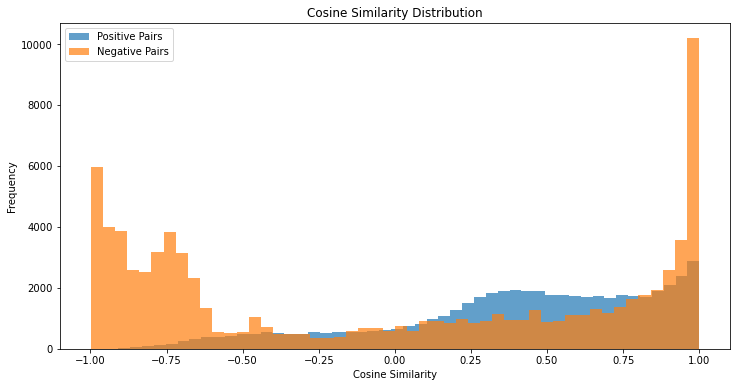

In [19]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarities from a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (tensor of shape [N, D]) and edge_indices (tensor of shape [num_edges, 2]),
    compute the cosine similarity for each edge.
    If skip_self is True, edges where source==target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        # Cosine similarity for unit-norm embeddings is just their dot product.
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0), embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Assuming:
# - all_predictions is a list (length >= num_events) of NumPy arrays,
#   where each element is an array of embeddings for one event.
# - data_test is a list (length >= num_events) of data objects with attribute 'assoc'
#   which is an array of group labels (e.g., [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2]).
# For each event, positive pairs are those nodes with the same label,
# and negative pairs are those nodes with different labels.

num_events = 10
all_pos_sims = []
all_neg_sims = []

# Loop over events.
for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)

    pred_norm = F.normalize(pred_tensor, p=2, dim=1)
    
    # Get the association labels for each node.
    # Here, assoc should be a list or array of integers.
    assoc = data_test[i].assoc  
    num_nodes = len(assoc)

    
    # Build edge lists based on the association groups.
    pos_edges = []
    neg_edges = []
    for src in range(num_nodes):
        for tgt in range(src + 1, num_nodes):  # only consider each pair once
            if assoc[src] == assoc[tgt]:
                pos_edges.append([src, tgt])
            else:
                neg_edges.append([src, tgt])

    # Convert edge lists to tensors.
    pos_edges_tensor = torch.tensor(pos_edges, dtype=torch.long)
    neg_edges_tensor = torch.tensor(neg_edges, dtype=torch.long)
    
    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(pred_norm, pos_edges_tensor, skip_self=True)

    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution")
plt.legend()
plt.show()


Processing events:   0%|                                                                                                                                                             | 0/10 [00:00<?, ?it/s]

tensor([[-3.5398,  3.8504,  4.8437,  ..., -0.3965, -2.5470,  3.2175],
        [-3.4963,  3.7225,  4.8493,  ..., -0.4348, -2.5496,  3.2375],
        [-3.6889,  3.9681,  4.9592,  ..., -0.4252, -2.6570,  3.3730],
        ...,
        [-3.1041,  2.2825,  4.4489,  ..., -2.4326, -2.1474,  2.8963],
        [-5.1955,  3.6944,  6.3116,  ..., -4.0772, -3.9471,  5.6236],
        [-5.8394,  3.7366,  6.5005,  ..., -5.2305, -4.3046,  6.3530]])


Processing events:  10%|██████████████▉                                                                                                                                      | 1/10 [00:00<00:01,  4.52it/s]

[0.99894935 0.99954176 0.99843115 ... 0.95647478 0.95246053 0.99600804]
[0.61455244 0.62236327 0.64241064 ... 0.88522506 0.82186997 0.85879195]
tensor([[-2.1967,  1.6695,  3.9155,  ..., -1.4564, -1.8057,  2.5062],
        [-2.1440,  1.5770,  3.8060,  ..., -1.4658, -1.7496,  2.4707],
        [-2.2605,  1.7581,  3.9955,  ..., -1.4697, -1.8571,  2.5630],
        ...,
        [-4.7010,  2.9118,  5.5004,  ..., -4.4364, -3.3779,  5.0691],
        [-4.2072,  3.1798,  5.4297,  ..., -3.1154, -3.0819,  4.3484],
        [-4.5491,  3.8076,  5.8544,  ..., -2.7506, -3.4463,  4.8257]])
[0.99985522 0.99985558 0.9994449  ... 0.98934817 0.96601439 0.98911613]
[]
tensor([[-1.8388,  1.5090,  3.6727,  ..., -1.1437, -1.5303,  2.0867],
        [-1.8325,  1.5134,  3.6802,  ..., -1.0862, -1.5276,  2.0564],
        [-1.7340,  1.3415,  3.5472,  ..., -1.0743, -1.4508,  1.9901],
        ...,
        [-5.5974,  6.9564,  5.4368,  ...,  0.3348, -3.5986,  4.3161],
        [-6.9426,  3.0941,  5.8564,  ..., -8.3216, -4.

Processing events:  30%|████████████████████████████████████████████▋                                                                                                        | 3/10 [00:00<00:01,  5.24it/s]

[0.9998644  0.99905032 0.99879086 ... 0.65256143 0.63667446 0.99897933]
[]
tensor([[-5.8347,  3.4038,  5.7392,  ..., -6.0974, -4.4082,  6.9939],
        [-4.7826,  2.7987,  5.1166,  ..., -5.0658, -3.6835,  5.8028],
        [-4.7269,  2.8962,  5.2581,  ..., -4.7850, -3.6787,  5.6823],
        ...,
        [-5.7512,  5.5868,  6.8668,  ..., -1.8461, -4.3034,  5.6848],
        [-3.4867,  2.2992,  4.6506,  ..., -3.1317, -2.4003,  3.3917],
        [-1.8917,  1.8720,  3.4541,  ..., -0.9099, -1.1308,  1.3204]])


Processing events:  40%|███████████████████████████████████████████████████████████▌                                                                                         | 4/10 [00:00<00:01,  4.68it/s]

[0.99918228 0.99820644 0.99967945 ... 0.85532349 0.73777235 0.90189898]
[0.5968821  0.58491355 0.58363926 ... 0.68732285 0.96046191 0.90182149]
tensor([[-5.0894,  6.0852,  5.1926,  ...,  0.3874, -3.3311,  4.0866],
        [-4.7775,  5.3486,  5.2003,  ...,  0.0539, -3.2465,  4.0301],
        [-5.2388,  5.9630,  5.3948,  ...,  0.1565, -3.5248,  4.3550],
        ...,
        [-2.9377,  2.1714,  4.3810,  ..., -2.2736, -2.0953,  2.8285],
        [-5.8114,  3.8995,  6.5599,  ..., -4.9668, -4.4245,  6.6047],
        [-5.8188,  5.2430,  6.8813,  ..., -2.5327, -4.3543,  5.9439]])


Processing events:  50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 5/10 [00:01<00:01,  3.17it/s]

[0.99426049 0.99583626 0.99661756 ... 0.93475497 0.8934325  0.95876485]
[0.59884501 0.55423295 0.5460484  ... 0.91036487 0.93277228 0.99101192]
tensor([[-1.9744,  2.3466,  3.2645,  ...,  0.0306, -1.3114,  1.5597],
        [-1.9529,  2.3466,  3.2363,  ...,  0.0350, -1.2792,  1.5116],
        [-1.7521,  1.9743,  3.2295,  ..., -0.2976, -1.1249,  1.3469],
        ...,
        [-6.2781,  3.0535,  5.8246,  ..., -7.1552, -4.3791,  7.0729],
        [-2.3754,  1.0677,  3.2194,  ..., -2.7176, -1.2750,  1.9685],
        [-3.0467,  2.1752,  4.3330,  ..., -2.5000, -2.0733,  2.8840]])


Processing events:  60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6/10 [00:01<00:01,  2.79it/s]

[0.99960625 0.98753738 0.9998697  ... 0.86463928 0.93094617 0.9395135 ]
[0.86713618 0.86752379 0.85559845 ... 0.96252042 0.93147343 0.90353215]
tensor([[-2.2146,  1.4808,  3.8900,  ..., -1.9779, -1.8476,  2.5861],
        [-2.2887,  1.4234,  3.8549,  ..., -2.1872, -1.9275,  2.7616],
        [-2.6327,  1.3925,  3.8535,  ..., -2.8620, -2.1492,  3.2654],
        ...,
        [-6.1754,  5.8703,  7.0179,  ..., -2.2053, -4.5852,  6.1478],
        [-4.1115,  5.0040,  4.6902,  ...,  0.0638, -2.6489,  3.1509],
        [-6.5877,  9.2808,  4.9018,  ...,  1.7483, -3.8454,  4.3909]])


Processing events:  70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 7/10 [00:02<00:01,  2.56it/s]

[0.99824673 0.98492497 0.99656212 ... 0.8910417  0.8142646  0.96661854]
[0.92555356 0.9543367  0.94041598 ... 0.66231698 0.74583119 0.60638499]
tensor([[-1.8513,  1.2330,  3.4600,  ..., -1.7033, -1.4421,  1.9948],
        [-1.7550,  1.1457,  3.3755,  ..., -1.6074, -1.3750,  1.9243],
        [-1.6355,  0.9547,  3.1902,  ..., -1.5777, -1.2575,  1.8493],
        ...,
        [-2.2605,  2.4547,  3.5723,  ..., -0.7552, -1.3183,  1.4997],
        [-4.6693,  2.1453,  4.9433,  ..., -5.5320, -3.1654,  5.0094],
        [-6.7039,  6.8603,  7.2472,  ..., -1.7757, -4.9014,  6.4175]])
[0.99974376 0.99837899 0.99491948 ... 0.7761367  0.75236589 0.76551753]
[]
tensor([[ -2.4381,   0.6783,   3.0084,  ...,  -3.2587,  -1.2464,   2.2350],
        [ -2.3871,   0.6245,   2.9477,  ...,  -3.2079,  -1.1924,   2.1942],
        [ -2.1423,   0.6659,   2.9257,  ...,  -2.7800,  -1.1055,   1.9129],
        ...,
        [ -5.9538,   5.8617,   6.8562,  ...,  -1.6443,  -4.3509,   5.7309],
        [-12.0629,  13.6640,  

Processing events:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 9/10 [00:02<00:00,  3.40it/s]

[0.99995846 0.99795812 0.99972236 ... 0.96263206 0.94469833 0.99500871]
[0.54030758 0.51954967 0.52571195 ... 0.60575271 0.49770811 0.46493682]
tensor([[-3.6097,  2.4954,  4.9364,  ..., -3.2100, -2.8593,  4.2941],
        [-3.7337,  2.4598,  4.9245,  ..., -3.4936, -2.9476,  4.4720],
        [-3.5492,  2.4625,  4.9207,  ..., -3.0852, -2.8266,  4.1957],
        ...,
        [-6.6931,  4.3637,  6.8274,  ..., -6.0434, -4.9736,  7.7527],
        [-4.1329,  2.9101,  5.4185,  ..., -3.2039, -3.1511,  4.6000],
        [-6.5216,  3.0450,  5.6217,  ..., -7.7409, -4.6673,  7.7365]])


Processing events: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.05it/s]

[0.99932098 0.9998759  0.9936825  ... 0.98361385 0.96794713 0.94421953]
[0.60293847 0.6205588  0.60267758 ... 0.58707291 0.66280812 0.51943028]


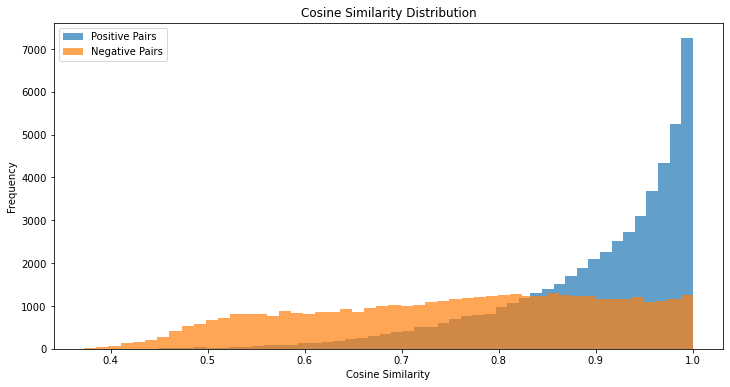

In [18]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarities from a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (tensor of shape [N, D]) and edge_indices (tensor of shape [num_edges, 2]),
    compute the cosine similarity for each edge.
    If skip_self is True, edges where source==target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        # Cosine similarity for unit-norm embeddings is just their dot product.
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0), embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Assuming:
# - all_predictions is a list (length >= num_events) of NumPy arrays,
#   where each element is an array of embeddings for one event.
# - data_test is a list (length >= num_events) of data objects with attribute 'assoc'
#   which is an array of group labels (e.g., [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2]).
# For each event, positive pairs are those nodes with the same label,
# and negative pairs are those nodes with different labels.

num_events = 10
all_pos_sims = []
all_neg_sims = []

# Loop over events.
for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    print(pred_tensor)
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)
    
    # Get the association labels for each node.
    # Here, assoc should be a list or array of integers.
    assoc = data_test[i].assoc  
    num_nodes = len(assoc)

    
    # Build edge lists based on the association groups.
    pos_edges = []
    neg_edges = []
    for src in range(num_nodes):
        for tgt in range(src + 1, num_nodes):  # only consider each pair once
            if assoc[src] == assoc[tgt]:
                pos_edges.append([src, tgt])
            else:
                neg_edges.append([src, tgt])

    # Convert edge lists to tensors.
    pos_edges_tensor = torch.tensor(pos_edges, dtype=torch.long)
    neg_edges_tensor = torch.tensor(neg_edges, dtype=torch.long)
    
    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(pred_norm, pos_edges_tensor, skip_self=True)
    neg_sims = compute_cosine_similarities(pred_norm, neg_edges_tensor, skip_self=True)
    print(pos_sims)
    print(neg_sims)
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution")
plt.legend()
plt.show()


In [ ]:
print(type(GT_ind[0][0]))
print(type(GT_ind2[0][0]))

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # For progress bar

def calculate_sim_to_reco_score(CaloParticle, energies_indices, ReconstructedTrackster, Multi):
    """
    Calculate the sim-to-reco score for a given CaloParticle and ReconstructedTrackster.
    
    Parameters:
    - CaloParticle: array of Layer Clusters in the CaloParticle.
    - Multiplicity: array of Multiplicity for layer clusters in CP
    - energies_indices: array of energies associated with all LC (indexed by LC).
    - ReconstructedTrackster: array of LC in the reconstructed Trackster.
    
    Returns:
    - sim_to_reco_score: the calculated sim-to-reco score.
    """
    numerator = 0.0
    denominator = 0.0

    energy_caloparticle_lc = energies_indices[CaloParticle] / Multi
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    if total_energy_caloparticle == 0:
        return 1.0  # No energy in the CaloParticle implies perfect mismatch

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    i = 0
    # Iterate over all DetIds in the CaloParticle
    for det_id in CaloParticle:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in CaloParticle
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1 if det_id in ReconstructedTrackster else 0.0
        # Fraction of energy in the CaloParticle (fr_k^SC)
        fr_sc_k = 1 / Multi[i]

        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_sc_k ** 2                # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_sc_k ** 2) * (energy_k ** 2)
        i+=1

    # Calculate score
    sim_to_reco_score = numerator / denominator if denominator != 0 else 1.0
    return sim_to_reco_score

def calculate_reco_to_sim_score(ReconstructedTrackster, energies_indices, CaloParticle, Multi):
    """
    Calculate the reco-to-sim score for a given ReconstructedTrackster and CaloParticle.

    Parameters:
    - ReconstructedTrackster: array of DetIds in the ReconstructedTrackster.
    - energies_indices: array of energies associated with all DetIds (indexed by DetId).
    - CaloParticle: array of DetIds in the CaloParticle.

    Returns:
    - reco_to_sim_score: the calculated reco-to-sim score.
    """
    numerator = 0.0
    denominator = 0.0

    # Calculate total energy of the ReconstructedTrackster
    total_energy_trackster = sum(energies_indices[det_id] for det_id in ReconstructedTrackster)
    if total_energy_trackster == 0:
        return 1.0  # No energy in the Trackster implies perfect mismatch

    energy_caloparticle_lc = energies_indices[CaloParticle] / Multi
    total_energy_caloparticle = sum(energy_caloparticle_lc)
    # Iterate over all DetIds in the ReconstructedTrackster
    for det_id in ReconstructedTrackster:
        energy_k = energies_indices[det_id]  # Energy for the current DetId in the Trackster
        
        # Fraction of energy in the Trackster (fr_k^TST)
        fr_tst_k = 1

        #fr_sc_k = 1 if det_id in CaloParticle else 0.0
        if det_id in CaloParticle:
            index = np.where(CaloParticle == det_id)[0][0]  # Find the index
            Multiplicity = Multi[index]
            fr_sc_k = 1
        else:
            fr_sc_k = 0
            
        # Update numerator using the min function
        numerator += min(
            (fr_tst_k - fr_sc_k) ** 2,  # First term in the min function
            fr_tst_k ** 2               # Second term in the min function
        ) * (energy_k ** 2)

        # Update denominator
        denominator += (fr_tst_k ** 2) * (energy_k ** 2)

    # Calculate score
    reco_to_sim_score = numerator / denominator if denominator != 0 else 1.0
    return reco_to_sim_score
def calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, multi, num_events = 100):
    """
    Calculate sim-to-reco and reco-to-sim scores for all CaloParticle and ReconstructedTrackster combinations across all events.

    Parameters:
    - GT_ind: List of CaloParticle indices for all events.
    - energies: List of energy arrays for all events.
    - recon_ind: List of ReconstructedTrackster indices for all events.
    - LC_x, LC_y, LC_z, LC_eta: Lists of x, y, z positions and eta values for all DetIds across events.

    Returns:
    - DataFrame containing scores and additional features for each CaloParticle-Trackster combination across all events.
    """
    # Initialize an empty list to store results
    all_results = []

    # Loop over all events with a progress bar
    for event_index in tqdm(range(num_events)):
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_multi = multi[event_index]

        # Extract layer cluster positions and eta for this event
        event_x = np.array(LC_x[event_index])
        event_y = np.array(LC_y[event_index])
        event_z = np.array(LC_z[event_index])
        event_eta = np.array(LC_eta[event_index])

        # Compute barycenter for each CaloParticle
        cp_barycenters = []
        cp_avg_etas = []
        for caloparticle in caloparticles:
            # Compute barycenter (x, y, z)
            
            barycenter_x = np.mean([event_x[det_id] for det_id in caloparticle])
            barycenter_y = np.mean([event_y[det_id] for det_id in caloparticle])
            barycenter_z = np.mean([event_z[det_id] for det_id in caloparticle])
            cp_barycenters.append(np.array([barycenter_x, barycenter_y, barycenter_z]))
            
            # Compute average eta
            avg_eta = np.mean([event_eta[det_id] for det_id in caloparticle])
            cp_avg_etas.append(avg_eta)

        # Compute separation between two CaloParticles if at least two exist
        if len(cp_barycenters) >= 2:
            cp_separation = np.linalg.norm(cp_barycenters[0] - cp_barycenters[1])
        else:
            cp_separation = 0.0
            
        trackster_det_id_sets = [set(trackster) for trackster in tracksters]

        # Loop over all CaloParticles
        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            calo_det_ids = set(calo_id for calo_id in caloparticle)
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                trackster_det_ids = trackster_det_id_sets[trackster_idx]
                shared_det_ids = calo_det_ids.intersection(trackster_det_ids)
                
                # Calculate shared_energy by summing energies of shared det_ids
                shared_energy = np.sum(event_energies[list(shared_det_ids)]) if shared_det_ids else 0.0
                
                
                sim_to_reco_score = calculate_sim_to_reco_score(caloparticle, event_energies, trackster, Calo_multi)
                # Calculate reco-to-sim score
                reco_to_sim_score = calculate_reco_to_sim_score(trackster, event_energies, caloparticle, Calo_multi)

                # Calculate total energy for CaloParticle and Trackster
                cp_energy_lc2 = event_energies[caloparticle] / Calo_multi
                cp_energy = np.sum(cp_energy_lc2)
                
                trackster_energy = np.sum([event_energies[det_id] for det_id in trackster])

                # Calculate energy difference ratio
                energy_diff_ratio = (trackster_energy / cp_energy if cp_energy != 0 else None)

                # Append results
                all_results.append({
                    "event_index": event_index,
                    "cp_id": calo_idx,
                    "trackster_id": trackster_idx,
                    "sim_to_reco_score": sim_to_reco_score,
                    "reco_to_sim_score": reco_to_sim_score,
                    "cp_energy": cp_energy,
                    "trackster_energy": trackster_energy,
                    "cp_avg_eta": cp_avg_etas[calo_idx],
                    "cp_separation": cp_separation,
                    "energy_ratio": energy_diff_ratio,
                    "shared_energy": shared_energy  # New column
                })

    # Convert results to a DataFrame
    df = pd.DataFrame(all_results)
    return df



In [ ]:
print(all_cluster_labels[0])

In [ ]:
#4: Calculate Scores and create DF for our model and TICL

#4.1: Turn the cluster labels into our reconstructed tracksters

recon_ind = []

for event_idx, labels in enumerate(all_cluster_labels):

    event_clusters = {} 
    
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].extend(Track_ind[event_idx][cluster_idx])
    
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

#4.2 Make DF from our model and CERN


In [ ]:
df_CL = calculate_all_event_scores(GT_ind, energies, recon_ind, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)
df_TICL = calculate_all_event_scores(GT_ind, energies, MT_ind_filt, LC_x, LC_y, LC_z, LC_eta, GT_mult, num_events = 1000)

In [ ]:
df_CL2 = pd.read_csv('df_scores_noRepeats.csv')
df_TICL2 = pd.read_csv('df_CERN_noRepeats.csv')

In [ ]:
#5: Print metrics

def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    # Step 1: Filter out rows where 'cp_id' is NaN
    cp_valid = df.dropna(subset=['cp_id']).copy()

    # Step 2: Group by 'event_index' and 'cp_id' to proess each CaloParticle individually
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])

    # Step 3: For each CaloParticle, check if any 'shared_energy' >= 50% of 'cp_energy'
    def is_cp_associated(group):
        cp_energy = group['cp_energy'].iloc[0]  # Assuming 'cp_energy' is consistent within the group
        threshold = 0.5 * cp_energy
        return (group['shared_energy'] >= threshold).any()

    # Apply the association function to each group
    cp_associated = cp_grouped.apply(is_cp_associated)

    # Step 4: Calculate the number of associated CaloParticles and total CaloParticles
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0
    
        # ----- Containment Calculation -----
    cp_valid_cont = df.dropna(subset=['cp_id']).copy()
    cp_grouped_cont = cp_valid_cont.groupby(['event_index', 'cp_id'])
    cp_associated_cont = cp_grouped_cont['sim_to_reco_score'].min() < 0.2
    num_associated_cp_cont = cp_associated_cont.sum()
    total_cp_cont = cp_associated_cont.count()
    containment = num_associated_cp_cont / total_cp_cont if total_cp_cont > 0 else 0


    # Print results for the model
    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Containment: {containment:.4f} ({num_associated_cp_cont} associated CPs out of {total_cp_cont} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num tracksters ratio: {total_tst / total_cp if total_cp > 0 else 0:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity
    }

# Example usage
our_model_metrics = calculate_metrics(df_CL, "Our Model")
cern_model_metrics = calculate_metrics(df_CL2, "CERN Model")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_CL and df_TICL are your two DataFrames
# Replace the following with your actual data loading mechanism
# df_CL = pd.read_csv('df_CL.csv')
# df_TICL = pd.read_csv('df_TICL.csv')

# ----- Preprocessing -----
# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['shared_energy'] = pd.to_numeric(df['shared_energy'], errors='coerce')  # New Column
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

def prepare_cp_data(df):
    """
    Group the DataFrame by ['event_index', 'cp_id'] so that each caloparticle is counted once.
    For each group:
      - Take the first cp_energy (they are identical).
      - Take the maximum shared_energy to check if any shared_energy >= 50% of cp_energy.
      - Mark the caloparticle as 'reconstructed' if any shared_energy >= 50% of cp_energy.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',          
        'shared_energy': 'max'        # Use max to determine if any shared_energy meets the threshold
    }).reset_index()
    
    # Mark as reconstructed if any shared_energy >= 50% of cp_energy.
    grouped['reco'] = (grouped['shared_energy'] >= 0.5 * grouped['cp_energy']).astype(int)
    return grouped

# Prepare the caloparticle data for both DataFrames.
df_CL_cp = prepare_cp_data(df_CL)
df_TICL_cp = prepare_cp_data(df_TICL)

# ----- Bin Caloparticles by Energy -----
# Define energy bins based on the range of cp_energy from df_CL.
min_energy = df_CL_cp['cp_energy'].min()
max_energy = df_CL_cp['cp_energy'].max()
n_bins = 10
energy_bins = np.linspace(min_energy, max_energy, n_bins + 1)

# Assign each caloparticle to an energy bin.
df_CL_cp['energy_bin'] = pd.cut(df_CL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)
df_TICL_cp['energy_bin'] = pd.cut(df_TICL_cp['cp_energy'], bins=energy_bins, labels=False, include_lowest=True)

# ----- Calculate Efficiency per Energy Bin -----
def aggregate_efficiency(df):
    """
    For each energy bin, calculate:
      - The total number of caloparticles in the bin.
      - The number of reconstructed caloparticles.
      - Efficiency = (number of reconstructed) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cp=('cp_energy', 'count'),
        reco_cp=('reco', 'sum')
    ).reset_index()
    agg['efficiency'] = agg['reco_cp'] / agg['total_cp']
    
    agg['eff_error'] = np.sqrt(agg['efficiency'] * (1 - agg['efficiency']) / agg['total_cp'])
    return agg

agg_CL = aggregate_efficiency(df_CL_cp)
agg_TICL = aggregate_efficiency(df_TICL_cp)

# ----- Plot Efficiency vs Energy with Histogram Overlay -----
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2
bar_width = energy_bins[1] - energy_bins[0]

eff_ratio = agg_CL['efficiency'] / agg_TICL['efficiency']
eff_ratio_error = eff_ratio * np.sqrt(
    (agg_CL['eff_error'] / agg_CL['efficiency'])**2 + 
    (agg_TICL['eff_error'] / agg_TICL['efficiency'])**2
)


# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)


# Plot Efficiency
ax1.errorbar(bin_centers, agg_CL['efficiency'], yerr=agg_CL['eff_error'], marker='o',linestyle ='--',  color='blue', label='Our Model')
ax1.errorbar(bin_centers, agg_TICL['efficiency'], yerr=agg_TICL['eff_error'],   marker='x', linestyle ='--', color='green', label='TICL')
ax1.set_ylabel('Efficiency', fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)



# ----- Histogram for Number of CaloParticles -----
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers, agg_CL['total_cp'], width=bar_width, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of CaloParticles', fontsize=12)
ax1_hist.set_ylim(0, agg_CL['total_cp'].max() * 1.2)

# ----- Ratio Plot -----
ax2.errorbar(bin_centers, eff_ratio, yerr=eff_ratio_error, fmt='x', color='blue', markersize=10)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.95, 1.05)

# Update Title to Reflect New Efficiency Definition
plt.title(r'Efficiency vs CaloParticle Energy: 5 Electron', fontsize=14)
plt.tight_layout()
plt.savefig("plots/efficiency.png")
plt.show()


In [ ]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['cp_id'] = pd.to_numeric(df['cp_id'], errors='coerce')
    df['sim_to_reco_score'] = pd.to_numeric(df['sim_to_reco_score'], errors='coerce')
    df['cp_energy'] = pd.to_numeric(df['cp_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for containment
# -----------------------------
def prepare_cont_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first cp_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'cp_id']).agg({
        'cp_energy': 'first',       # Use the first cp_energy value.
        'sim_to_reco_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['sim_to_reco_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_cont = prepare_cont_data(df_CL)
df_TICL_cont   = prepare_cont_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of cp_energy from df_CL.
min_energy_cont = df_CL_cont['cp_energy'].min()
max_energy_cont = df_CL_cont['cp_energy'].max()
n_bins_cont = 10  # Adjust the number of bins if desired.
energy_bins_cont = np.linspace(min_energy_cont, max_energy_cont, n_bins_cont + 1)

# Assign each trackster to an energy bin.
df_CL_cont['energy_bin'] = pd.cut(df_CL_cont['cp_energy'],
                                    bins=energy_bins_cont, labels=False, include_lowest=True)
df_TICL_cont['energy_bin']   = pd.cut(df_TICL_cont['cp_energy'],
                                    bins=energy_bins_cont, labels=False, include_lowest=True)

# -----------------------------
# Calculate containment per Energy Bin
# -----------------------------
def aggregate_containment(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - containment = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_cont = ('cp_energy', 'count'),
        assoc_cont = ('assoc', 'sum')
    ).reset_index()
    agg['containment'] = agg['assoc_cont'] / agg['total_cont']
    
    agg['containment_error'] = np.sqrt(agg['containment'] * (1 - agg['containment']) / agg['total_cont'])
    return agg

agg_CL_cont = aggregate_containment(df_CL_cont)
agg_TICL_cont   = aggregate_containment(df_TICL_cont)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_cont-1)
agg_CL_cont = agg_CL_cont.set_index('energy_bin').reindex(range(n_bins_cont), fill_value=np.nan).reset_index()
agg_TICL_cont   = agg_TICL_cont.set_index('energy_bin').reindex(range(n_bins_cont), fill_value=np.nan).reset_index()

# -----------------------------
# Plot containment vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_cont = (energy_bins_cont[:-1] + energy_bins_cont[1:]) / 2
bar_width_cont = energy_bins_cont[1] - energy_bins_cont[0]

containment_ratio = agg_CL_cont['containment'] / agg_TICL_cont['containment']
containment_ratio_error = containment_ratio * np.sqrt(
    (agg_CL_cont['containment_error'] / agg_CL_cont['containment'])**2 +
    (agg_TICL_cont['containment_error'] / agg_TICL_cont['containment'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot containment curves on the primary y-axis.
ax1.errorbar(bin_centers_cont, agg_CL_cont['containment'], yerr=agg_CL_cont['containment_error'], marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_cont, agg_TICL_cont['containment'], yerr = agg_TICL_cont['containment_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('containment')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_cont, agg_CL_cont['total_cont'], width=bar_width_cont, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_cont['total_cont'].max() * 1.2)

ax2.errorbar(bin_centers_cont, containment_ratio, yerr=containment_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('CaloParticle [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.6, 1.05)

plt.title(r'containment vs Merged Trackster Energy: 5 Pion', fontsize=14)
plt.savefig("plots/containment.png")
plt.show()

In [ ]:

# Convert relevant columns to numeric.
for df in [df_CL, df_TICL]:
    df['trackster_id'] = pd.to_numeric(df['trackster_id'], errors='coerce')
    df['reco_to_sim_score'] = pd.to_numeric(df['reco_to_sim_score'], errors='coerce')
    df['trackster_energy'] = pd.to_numeric(df['trackster_energy'], errors='coerce')

# -----------------------------
# Prepare Trackster-Level Data for Purity
# -----------------------------
def prepare_trackster_data(df):
    """
    Group the DataFrame by ['event_index', 'trackster_id'] so that each trackster is counted once.
    For each group:
      - Take the first trackster_energy,
      - Take the minimum reco_to_sim_score,
      - Mark the trackster as 'associated' if the minimum reco_to_sim_score is < 0.2.
    """
    grouped = df.groupby(['event_index', 'trackster_id']).agg({
        'trackster_energy': 'first',       # Use the first trackster_energy value.
        'reco_to_sim_score': 'min'           # Minimum score among the rows for that trackster.
    }).reset_index()
    
    # Mark as associated if reco_to_sim_score is < 0.2.
    grouped['assoc'] = (grouped['reco_to_sim_score'] < 0.2).astype(int)
    return grouped

# Prepare the trackster-level data for both DataFrames.
df_CL_ts = prepare_trackster_data(df_CL)
df_TICL_ts   = prepare_trackster_data(df_TICL)

# -----------------------------
# Bin Tracksters by Energy
# -----------------------------
# Define energy bins based on the range of trackster_energy from df_CL.
min_energy_ts = df_CL_ts['trackster_energy'].min()
max_energy_ts = 300
n_bins_ts = 10  # Adjust the number of bins if desired.
energy_bins_ts = np.linspace(min_energy_ts, max_energy_ts, n_bins_ts + 1)

# Assign each trackster to an energy bin.
df_CL_ts['energy_bin'] = pd.cut(df_CL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)
df_TICL_ts['energy_bin']   = pd.cut(df_TICL_ts['trackster_energy'],
                                    bins=energy_bins_ts, labels=False, include_lowest=True)

# -----------------------------
# Calculate Purity per Energy Bin
# -----------------------------
def aggregate_purity(df):
    """
    For each energy bin, calculate:
      - Total number of tracksters,
      - Number of associated tracksters (with reco_to_sim_score < 0.2),
      - Purity = (number of associated tracksters) / (total number).
    """
    agg = df.groupby('energy_bin').agg(
        total_ts = ('trackster_energy', 'count'),
        assoc_ts = ('assoc', 'sum')
    ).reset_index()
    agg['purity'] = agg['assoc_ts'] / agg['total_ts']
    
    agg['purity_error'] = np.sqrt(agg['purity'] * (1 - agg['purity']) / agg['total_ts'])
    return agg

agg_CL_ts = aggregate_purity(df_CL_ts)
agg_TICL_ts   = aggregate_purity(df_TICL_ts)

# Reindex both aggregated DataFrames so that they have one row per energy bin (0 to n_bins_ts-1)
agg_CL_ts = agg_CL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()
agg_TICL_ts   = agg_TICL_ts.set_index('energy_bin').reindex(range(n_bins_ts), fill_value=np.nan).reset_index()

# -----------------------------
# Plot Purity vs Trackster Energy with Histogram Overlay
# -----------------------------
# Compute bin centers for plotting: average of adjacent bin edges.
bin_centers_ts = (energy_bins_ts[:-1] + energy_bins_ts[1:]) / 2
bar_width_ts = energy_bins_ts[1] - energy_bins_ts[0]

purity_ratio = agg_CL_ts['purity'] / agg_TICL_ts['purity']
purity_ratio_error = purity_ratio * np.sqrt(
    (agg_CL_ts['purity_error'] / agg_CL_ts['purity'])**2 +
    (agg_TICL_ts['purity_error'] / agg_TICL_ts['purity'])**2
)

# Create a figure with two y-axes.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

plt.subplots_adjust(hspace=0.1)  # Set spacing to zero

# Plot purity curves on the primary y-axis.
ax1.errorbar(bin_centers_ts, agg_CL_ts['purity'], yerr = agg_CL_ts['purity_error'],marker='o', linestyle='--', color = 'blue', label='Our Model')
ax1.errorbar(bin_centers_ts, agg_TICL_ts['purity'], yerr = agg_TICL_ts['purity_error'], marker='x', linestyle='--', color = 'green', label='TICL')
ax1.set_ylabel('Purity')
ax1.set_ylim(0, 1.05)
ax1.legend(loc='lower right')
ax1.grid(True)

# Plot histogram (trackster count per energy bin) on the secondary y-axis.
ax1_hist = ax1.twinx()  # Create secondary y-axis for histogram
ax1_hist.bar(bin_centers_ts, agg_CL_ts['total_ts'], width=bar_width_ts, color='lightblue', alpha=0.4)
ax1_hist.set_ylabel('Number of Merged Tracksters', fontsize=12)
ax1_hist.set_ylim(0, agg_CL_ts['total_ts'].max() * 1.2)

ax2.errorbar(bin_centers_ts, purity_ratio, yerr=purity_ratio_error, fmt='x', color='blue', markersize=7)
ax2.axhline(1.0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Merged Trackster Energy [GeV]', fontsize=12)
ax2.set_ylabel('Ratio', fontsize=12)
ax2.set_ylim(0.95, 1.05)

plt.title(r'Purity vs Merged Trackster Energy: 5 Electron', fontsize=14)
plt.savefig("plots/Purity.png")

plt.show()


In [ ]:
df_CL

In [ ]:
df_CL_best[df_CL_best['energy_bin']==0].head(30)

# Response and Resolution

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ====================================================
# 1. Select Best RecoTrackster (Best Associated Trackster) per SimTrackster
# ====================================================
def select_best_trackster(df):
    """
    For each (event_index, cp_id) combination, select the row with the maximum shared_energy.
    This is assumed to give the best associated RecoTrackster for each SimTrackster.
    """
    df = df.copy()
    for col in ['cp_id', 'shared_energy', 'cp_energy', 'trackster_energy']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df_best = (df.groupby(['event_index', 'cp_id'], as_index=False)
                 .apply(lambda g: g.loc[g['shared_energy'].idxmax()])
                 .reset_index(drop=True))
    return df_best

# Process both dataframes (df_CL and df_TICL)
df_CL_best   = select_best_trackster(df_CL)
df_TICL_best = select_best_trackster(df_TICL)

# ====================================================
# 2. Compute the Response Ratio = (raw energy / regressed energy)
# ====================================================
# Here we treat trackster_energy as the raw energy and cp_energy as the regressed energy.
df_CL_best['ratio']   = df_CL_best['trackster_energy'] / df_CL_best['cp_energy']
df_TICL_best['ratio'] = df_TICL_best['trackster_energy'] / df_TICL_best['cp_energy']

# ====================================================
# 3. Bin by regressed energy using specified bin centers
# ====================================================
# Define desired energy bin centers (in GeV)
centers = np.array([10, 20, 30, 40, 60, 80, 100, 150, 200])
n_bins = len(centers)

# Compute bin edges: use midpoints for interior edges; extrapolate for the first and last edge.
edges = np.empty(n_bins + 1)
edges[1:-1] = (centers[:-1] + centers[1:]) / 2.0
edges[0]    = centers[0] - (centers[1] - centers[0]) / 2.0
edges[-1]   = centers[-1] + (centers[-1] - centers[-2]) / 2.0

# Assign each event an energy bin based on its regressed energy (cp_energy)
df_CL_best['energy_bin']   = pd.cut(df_CL_best['cp_energy'], bins=edges, labels=False)
df_TICL_best['energy_bin'] = pd.cut(df_TICL_best['cp_energy'], bins=edges, labels=False)

# ====================================================
# 4. Compute Sigma Effective on the Scaled Response for Each Energy Bin
# ====================================================
def compute_sigma_effective_scaled(df, n_bins):
    """
    For each energy bin:
      - Extract the response ratio distribution.
      - Remove non-finite values.
      - Scale the distribution by dividing by its mean (so the mean becomes 1).
      - Compute sigma effective as half the width of the narrowest window that contains 68% of the scaled data.
      - Also compute an approximate error (sigma_eff / sqrt(N)).
    Returns arrays: sigma_eff_vals, sigma_eff_errs, and event counts per bin.
    """
    sigma_eff_vals = []
    sigma_eff_errs = []
    counts = []
    
    for b in range(n_bins):
        # Select data in the bin
        bin_data = df.loc[df['energy_bin'] == b, 'ratio'].dropna()
        # Filter: only finite values (optionally you may further restrict to [0,2])
        bin_data = bin_data[np.isfinite(bin_data)]
        bin_data = bin_data[(bin_data >= 0) & (bin_data <= 2)]
        counts.append(len(bin_data))
        
        if len(bin_data) == 0:
            sigma_eff_vals.append(np.nan)
            sigma_eff_errs.append(np.nan)
            continue
        
        # Scale the distribution by its mean so that the mean response becomes 1.
        mean_val = bin_data.mean()
        scaled = bin_data / mean_val
        
        # Compute sigma effective: half the width of the narrowest window containing 68% of the scaled data.
        sorted_scaled = np.sort(scaled)
        n_points = len(sorted_scaled)
        window_size = int(np.round(0.683 * n_points))
        if window_size < 1:
            window_size = 1
        
        min_width = np.inf
        best_range = (None, None)
        for i in range(n_points - window_size + 1):
            width = sorted_scaled[i + window_size - 1] - sorted_scaled[i]
            if width < min_width:
                min_width = width
                best_range = (sorted_scaled[i], sorted_scaled[i + window_size - 1])
        
        # Sigma effective is half the window width
        sigma_eff = (best_range[1] - best_range[0])
        sigma_eff_err = sigma_eff / np.sqrt(n_points) if n_points > 1 else np.nan
        
        sigma_eff_vals.append(sigma_eff)
        sigma_eff_errs.append(sigma_eff_err)
    
    return np.array(sigma_eff_vals), np.array(sigma_eff_errs), np.array(counts)

# Compute sigma effective for each energy bin for both data sets.
sigma_eff_CL, sigma_eff_err_CL, counts_CL = compute_sigma_effective_scaled(df_CL_best, n_bins)
sigma_eff_TICL, sigma_eff_err_TICL, counts_TICL = compute_sigma_effective_scaled(df_TICL_best, n_bins)

# ====================================================
# 4.5 Debug: Plot a few Histograms for Selected Energy Bins
# ====================================================
# For debugging, we display the scaled response histograms for a few bins.
# Here we choose the first, middle, and last energy bins.
debug_bins = [0, n_bins // 2, n_bins - 1]
fig, axes = plt.subplots(len(debug_bins), 2, figsize=(12, 4 * len(debug_bins)), sharex=True)
for j, b in enumerate(debug_bins):
    for dataset, df_best, ax in zip(["CL", "TICL"], [df_CL_best, df_TICL_best], axes[j]):
        # Get the ratio distribution for this energy bin.
        bin_data = df_best.loc[df_best['energy_bin'] == b, 'ratio'].dropna()
        bin_data = bin_data[np.isfinite(bin_data)]
        # (Optional) Restrict the ratio values to a reasonable range, e.g. [0, 2].
        bin_data = bin_data[(bin_data >= 0) & (bin_data <= 2)]
        if len(bin_data) == 0:
            ax.text(0.5, 0.5, "No data in bin", transform=ax.transAxes,
                    horizontalalignment="center")
            continue
        # Scale the distribution by its mean.
        mean_val = bin_data.mean()
        scaled = bin_data / mean_val
        
        # Compute sigma effective for this bin (for display purposes)
        sorted_scaled = np.sort(scaled)
        n_points = len(sorted_scaled)
        window_size = int(np.round(0.683 * n_points))
        if window_size < 1:
            window_size = 1
        min_width = np.inf
        best_range = (None, None)
        for i in range(n_points - window_size + 1):
            width = sorted_scaled[i + window_size - 1] - sorted_scaled[i]
            if width < min_width:
                min_width = width
                best_range = (sorted_scaled[i], sorted_scaled[i + window_size - 1])
        sigma_eff_this = (best_range[1] - best_range[0])
        
        # Plot the histogram of the scaled response
        ax.hist(scaled, bins=30, alpha=0.7, color='C0')
        ax.axvline(best_range[0], color='red', linestyle='--', label='68% window boundaries')
        ax.axvline(best_range[1], color='red', linestyle='--')
        ax.set_title(f"{dataset} Bin {b} (center ~ {centers[b]} GeV)\n sigma_eff = {sigma_eff_this:.3f}")
        ax.set_xlabel("Scaled Ratio")
        ax.set_ylabel("Counts")
        ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

# ====================================================
# 5. Final Plot: Normalized Sigma Effective vs. Regressed Energy
# ====================================================
# Normalize sigma effective by dividing by the corresponding energy bin center.
norm_sigma_eff_CL = sigma_eff_CL / centers
norm_sigma_eff_err_CL = sigma_eff_err_CL / centers

norm_sigma_eff_TICL = sigma_eff_TICL / centers
norm_sigma_eff_err_TICL = sigma_eff_err_TICL / centers

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(centers, norm_sigma_eff_CL, yerr=norm_sigma_eff_err_CL, fmt='bo-', capsize=5, label='CL')
ax.errorbar(centers, norm_sigma_eff_TICL, yerr=norm_sigma_eff_err_TICL, fmt='gs-', capsize=5, label='TICL')
ax.set_xlabel('Regressed Energy (GeV)', fontsize=14)
ax.set_ylabel('Normalized Sigma Effective', fontsize=14)
ax.set_title('Normalized Response Resolution vs. Regressed Energy', fontsize=16)
ax.grid(True)
ax.legend()
plt.show()


In [ ]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors

layer = data_file['clusters;3']['cluster_layer_id'].array()

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=10):
    # Define unique colors for caloparticles
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations

        # Simulated particle shower
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)

        # Reconstructed particle shower
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)

        # Calculate sim_to_reco score and determine associations


        for calo_idx, caloparticle in enumerate(caloparticles):
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            # Loop over all Tracksters
            max_shared_energy = 0.0
            best_tst_idx = None
            
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate sim-to-reco score
                
                
                shared_det_ids = set(calo_det_id for calo_det_id in caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared det_ids

                # Calculate shared_energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx

            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx
                    
        
        
        # Determine energy range from reconstructed showers for consistent y-axis
        min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
        max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
    
    
        # Plot simulated profiles
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'], marker='o', linestyle='-', color=colors[idx % len(colors)])
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1} (Event {event_index + 1})')
            ax.set_xlabel('Layer ID')
            ax.set_ylabel('Energy')

        # Plot all reconstructed profiles in a single plot
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Determine color based on association
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = colors[associated_cp[0] % len(colors)] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'], marker='x', linestyle='--', color=color)
        ax.set_ylim(min_energy, max_energy)
        ax.set_title(f'Reconstructed Showers (Event {event_index + 1})')
        ax.set_xlabel('Layer ID')
        ax.set_ylabel('Energy')

        # Show the plots
        plt.show()

events_ours = calculate_all_event_profile_data(GT_ind_filt, energies, recon_ind, layer, GT_mult_filt)


In [ ]:
events_TICL = calculate_all_event_profile_data(GT_ind_filt, energies, MT_ind_filt, layer, GT_mult_filt)

In [ ]:
# Plotting longitudinal energy profiles of both simulated and reconstructed showers along with associated pairs.

import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

# Define LC_x, LC_y, LC_z somewhere or import if needed.
# For example purposes, assume they are defined globally.

def calculate_all_event_profile_data(GT_ind, energies, recon_ind, layer, multi, num_events=5):
    # Define unique colors (using Tableau colors)
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Loop over all events
    for event_index in range(num_events):
        # Get data for the current event
        caloparticles = GT_ind[event_index]  # Indices for all CaloParticles in the event
        tracksters = recon_ind[event_index]  # Indices for all ReconstructedTracksters in the event
        event_energies = energies[event_index]  # Energies for this event
        event_layer_id = layer[event_index]
        event_multi = multi[event_index]
        event_LC_x = LC_x[event_index]
        event_LC_y = LC_y[event_index]
        event_LC_z = LC_z[event_index]

        # Initialize lists for profiles and associations
        simulated_profiles = []
        reconstructed_profiles = []
        associations = {}  # To store caloparticle-trackster associations
        cp_lc_pos_all = []
        cp_lc_energies_all = []
        tst_lc_pos_all = []
        tst_lc_energies_all = []
        total_cp_energies = []
        total_tst_energies = []

        # --- Simulated particle shower ---
        for cp_idx, caloparticle in enumerate(caloparticles):
            cp_lc_layer_id = event_layer_id[caloparticle]
            # Divide energy by multi (assume event_multi[cp_idx] corresponds to this caloparticle)
            cp_lc_energies = event_energies[caloparticle] / event_multi[cp_idx]
            df_cp = pd.DataFrame({'energy': cp_lc_energies, 'layer_id': cp_lc_layer_id})
            layer_energy_cp = df_cp.groupby('layer_id')['energy'].sum().reset_index()
            simulated_profiles.append(layer_energy_cp)
            
            cp_lc_pos_all.append([event_LC_x[caloparticle], event_LC_y[caloparticle], event_LC_z[caloparticle]])
            cp_lc_energies_all.append(cp_lc_energies)
            total_cp_energies.append(layer_energy_cp['energy'].sum())

        # Build a dedicated color map for simulated showers
        cp_color_map = {cp_idx: colors[cp_idx % len(colors)] for cp_idx in range(len(simulated_profiles))}

        # --- Reconstructed particle shower ---
        for trackster in tracksters:
            tst_lc_layer_id = event_layer_id[trackster]
            tst_lc_energies = event_energies[trackster]
            df_tst = pd.DataFrame({'energy': tst_lc_energies, 'layer_id': tst_lc_layer_id})
            layer_energy_tst = df_tst.groupby('layer_id')['energy'].sum().reset_index()
            reconstructed_profiles.append(layer_energy_tst)
            
            tst_lc_pos_all.append([event_LC_x[trackster], event_LC_y[trackster], event_LC_z[trackster]])
            tst_lc_energies_all.append(tst_lc_energies)
            total_tst_energy = np.sum(tst_lc_energies)
            total_tst_energies.append(layer_energy_tst['energy'].sum())

        # --- Calculate sim_to_reco score and determine associations ---
        for calo_idx, caloparticle in enumerate(caloparticles):
            # Use corresponding multiplicity for this calo particle
            Calo_multi = event_multi[calo_idx]
            cp_energy = np.sum(event_energies[caloparticle] / Calo_multi)
            
            max_shared_energy = 0.0
            best_tst_idx = None
            
            # Loop over all Tracksters
            for trackster_idx, trackster in enumerate(tracksters):
                # Calculate shared detector IDs (assuming caloparticle and trackster are lists/arrays of detector IDs)
                shared_det_ids = set(caloparticle).intersection(set(trackster))
                if not shared_det_ids:
                    continue  # No shared detector IDs

                # Calculate shared energy
                shared_energy = np.sum(event_energies[list(shared_det_ids)])

                # Check if shared_energy meets the threshold
                if shared_energy >= 0.5 * cp_energy and shared_energy > max_shared_energy:
                    max_shared_energy = shared_energy
                    best_tst_idx = trackster_idx
                    
            if best_tst_idx is not None:
                associations[calo_idx] = best_tst_idx

        # --- Determine energy range from reconstructed showers for consistent y-axis ---
        # (if there is at least one reconstructed profile)
        if reconstructed_profiles:
            min_energy = min(profile['energy'].min() for profile in reconstructed_profiles)
            max_energy = max(profile['energy'].max() for profile in reconstructed_profiles)
        else:
            min_energy, max_energy = 0, 1

        # --- Plot simulated profiles (2D) ---
        fig, axes = plt.subplots(1, len(simulated_profiles) + 1, figsize=(15, 3), constrained_layout=True)
        fig.suptitle(f'Event {event_index + 1}', fontsize=16)

        for idx, profile in enumerate(simulated_profiles):
            ax = axes[idx]
            ax.plot(profile['layer_id'], profile['energy'],
                    marker='o', linestyle='-', color=cp_color_map[idx],
                    label=f"E = {total_cp_energies[idx]:.2f} GeV")
            ax.set_ylim(min_energy, max_energy)
            ax.set_title(f'Simulated Shower {idx + 1}')
            ax.set_xlabel('Detector Layer')
            ax.set_ylabel('Energy')
            ax.legend()

        # --- Plot all reconstructed profiles in a single 2D plot ---
        ax = axes[-1]
        for idx, profile in enumerate(reconstructed_profiles):
            # Look up the corresponding calo (if any) using associations
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            # Use the simulated shower color if there is an association; otherwise, default to gray
            color = cp_color_map[associated_cp[0]] if associated_cp else 'gray'
            ax.plot(profile['layer_id'], profile['energy'],
                    marker='x', linestyle='--', color=color,
                    label=f"E = {total_tst_energies[idx]:.2f} GeV")
            
        ax.set_ylim(min_energy, max_energy)
        ax.set_title('Reconstructed Showers')
        ax.set_xlabel('Detector Layer')
        ax.set_ylabel('Energy')
        ax.legend(title='Reco Energies', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

        # --- Determine global energy scale and axis limits for 3D plots ---
        all_energies = np.concatenate(cp_lc_energies_all + tst_lc_energies_all)
        global_min_energy, global_max_energy = np.min(all_energies), np.max(all_energies)
        x_lim = [min(event_LC_x), max(event_LC_x)]
        y_lim = [min(event_LC_y), max(event_LC_y)]
        z_lim = [min(event_LC_z), max(event_LC_z)]

        # --- 3D Scatter Plot for All Simulated Layer Clusters ---
        fig3d = plt.figure(figsize=(15, 7))
        ax_3d = fig3d.add_subplot(1, 2, 1, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(cp_lc_pos_all, cp_lc_energies_all)):
            x, y, z = pos
            sizes = np.log1p(np.array(energies_)) * 100  # Scale sizes for visibility
            ax_3d.scatter(x, y, z, c=cp_color_map[idx], alpha=0.3, s=sizes, edgecolors='k', label=f'Shower {idx+1}')
        
        ax_3d.set_xlim(x_lim)
        ax_3d.set_ylim(y_lim)
        ax_3d.set_zlim(z_lim)
        ax_3d.set_title('3D visualisation of All Simulated Showers')
        ax_3d.set_xlabel('X')
        ax_3d.set_ylabel('Y')
        ax_3d.set_zlabel('Z')
        ax_3d.legend()

        # --- 3D Scatter Plot for All Reconstructed Tracksters ---
        ax_3d_reco = fig3d.add_subplot(1, 2, 2, projection='3d')
        for idx, (pos, energies_) in enumerate(zip(tst_lc_pos_all, tst_lc_energies_all)):
            x, y, z = pos
            sizes = np.log1p(np.array(energies_)) * 100  # Scale sizes for visibility
            # Look up association for the trackster to decide its color
            associated_cp = [cp_idx for cp_idx, tst_idx in associations.items() if tst_idx == idx]
            color = cp_color_map[associated_cp[0]] if associated_cp else 'gray'
            ax_3d_reco.scatter(x, y, z, c=color, alpha=0.3, s=sizes, edgecolors='k', label=f'Trackster {idx+1}')
        
        ax_3d_reco.set_xlim(x_lim)
        ax_3d_reco.set_ylim(y_lim)
        ax_3d_reco.set_zlim(z_lim)
        ax_3d_reco.set_title('3D visualisation of All Reconstructed Tracksters')
        ax_3d_reco.set_xlabel('X')
        ax_3d_reco.set_ylabel('Y')
        ax_3d_reco.set_zlabel('Z')
        ax_3d_reco.legend()

        plt.show()

        

events = calculate_all_event_profile_data(GT_ind_filt, energies, recon_ind, layer, GT_mult_filt)

In [ ]:
events = calculate_all_event_profile_data(GT_ind_filt, energies, MT_ind_filt, layer, GT_mult_filt)